In [ ]:
cd ..

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
import copy
import glob
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report

from src.dataloader import make_data_loader
from src.model_loader import load_model
from src.trainers import first_eval, class_report
from src.analytics import fix_state_dict, df_builder

## Setup 

create student and teacher models. Load them onto device.
gather teacher predictions over validation set.

In [4]:
dataloaders, dataset_sizes = make_data_loader(8, 'imagewoof')
student, teacher = load_model('models/baseline/imagewoof/vgg16.pth', 'imagewoof', 'vgg16')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

student = student.to(device)
teacher = teacher.to(device)

ground_labels, teacher_pred = class_report(teacher, dataloaders, dataset_sizes)
_, student_pred = class_report(student, dataloaders, dataset_sizes)

class_names = ["Shih-Tzu", "Rhodesian ridgeback", "Beagle", "English foxhound", "Australian terrier", "Border terrier", "Golden retriever", "Old English sheepdog", "Samoyed", "Dingo"]

report = classification_report(ground_labels, teacher_pred, target_names=class_names, output_dict=True)


in model
odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.runni

In [5]:
report

{'Shih-Tzu': {'precision': 0.8933002481389578,
  'recall': 0.8801955990220048,
  'f1-score': 0.8866995073891625,
  'support': 409},
 'Rhodesian ridgeback': {'precision': 0.8867924528301887,
  'recall': 0.9215686274509803,
  'f1-score': 0.9038461538461539,
  'support': 408},
 'Beagle': {'precision': 0.8412322274881516,
  'recall': 0.8492822966507177,
  'f1-score': 0.8452380952380952,
  'support': 418},
 'English foxhound': {'precision': 0.765,
  'recall': 0.6830357142857143,
  'f1-score': 0.7216981132075472,
  'support': 224},
 'Australian terrier': {'precision': 0.861904761904762,
  'recall': 0.9027431421446384,
  'f1-score': 0.881851400730816,
  'support': 401},
 'Border terrier': {'precision': 0.917098445595855,
  'recall': 0.8697788697788698,
  'f1-score': 0.8928121059268601,
  'support': 407},
 'Golden retriever': {'precision': 0.8948655256723717,
  'recall': 0.912718204488778,
  'f1-score': 0.9037037037037037,
  'support': 401},
 'Old English sheepdog': {'precision': 0.91846522781

Make PIE and classification report DF builder

In [6]:
dfs = df_builder(ground_labels, teacher_pred)

run model statistics over population for PIE and accuracy and ad them to data frame 

In [7]:
mag_30 = glob.glob('models/imagewoof/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.3/*.pt') 
mag_45 = glob.glob('models/imagewoof/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.45/*.pt')
mag_60 = glob.glob('models/imagewoof/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.6/*.pt')
mag_75 = glob.glob('models/imagewoof/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.75/*.pt')
mag_90 = glob.glob('models/imagewoof/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.9/*.pt')

models = [(mag_30, 30), (mag_45, 45), (mag_60, 60), (mag_75, 75), (mag_90, 90)]

for (paths, sparsity) in models:

    dfs.add_models(paths=paths, sparsity=sparsity, method='Struct Mag', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/inner-knowledge-pruning/src/analytics.py:98: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [8]:
ik_30 = glob.glob('models/imagewoof/vgg16/ik_struct_mag/lr_0.0005/alpha_0.1/sparsity_0.3/*.pt')
ik_45 = glob.glob('models/imagewoof/vgg16/ik_struct_mag/lr_0.0005/alpha_0.1/sparsity_0.45/*.pt')
ik_60 = glob.glob('models/imagewoof/vgg16/ik_struct_mag/lr_0.0005/alpha_0.1/sparsity_0.6/*.pt')
ik_75 = glob.glob('models/imagewoof/vgg16/ik_struct_mag/lr_0.0005/alpha_0.1/sparsity_0.75/*.pt')
ik_90 = glob.glob('models/imagewoof/vgg16/ik_struct_mag/lr_0.0005/alpha_0.1/sparsity_0.9/*.pt')

models = [(ik_30, 30), (ik_45, 45), (ik_60, 60), (ik_75, 75), (ik_90, 90)]

for (paths, sparsity) in models:
    dfs.add_models(paths=paths, sparsity=sparsity, method='IK Struct Mag', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


In [9]:
dfs.PIEs

,PIEs,method,sparsity
0,210.0,Struct Mag,30.0
1,205.0,Struct Mag,45.0
2,195.0,Struct Mag,60.0
3,204.0,Struct Mag,75.0
4,201.0,Struct Mag,90.0
5,141.0,IK Struct Mag,30.0
6,153.0,IK Struct Mag,45.0
7,141.0,IK Struct Mag,60.0
8,140.0,IK Struct Mag,75.0
9,149.0,IK Struct Mag,90.0


In [16]:
from sklearn.metrics import confusion_matrix
teacher_conf = confusion_matrix(ground_labels, teacher_pred)
FP_t = teacher_conf.sum(axis=0) - np.diag(teacher_conf)
FN_t = teacher_conf.sum(axis=1) - np.diag(teacher_conf)
TP_t = np.diag(teacher_conf)
TN_t = teacher_conf.sum() - (FP_t + FN_t + TP_t)

FPR_t = FP_t / (FP_t  + TN_t)
FNR_t = FN_t / (FN_t + TP_t)

IK_Stats = dfs.pruning_stats[np.logical_and(dfs.pruning_stats.method == 'IK Struct Mag', dfs.pruning_stats.sparsity == 30)]

mean_FPR_IK = IK_Stats.FP_r.mean(axis=0)
mean_FNR_IK = IK_Stats.FN_r.mean(axis=0)
FPR_IK_change = (mean_FPR_IK - FPR_t)/FPR_t * 100
FPN_IK_change = (mean_FNR_IK - FNR_t)/FNR_t * 100
print(FPR_IK_change)
print(FPN_IK_change)

Struct_Stats = dfs.pruning_stats[np.logical_and(dfs.pruning_stats.method == 'Struct Mag', dfs.pruning_stats.sparsity == 30)]
mean_FPR_Struct = Struct_Stats.FP_r.mean(axis=0)
mean_FNR_Struct = Struct_Stats.FN_r.mean(axis=0)
FPR_Struct_change = (mean_FPR_Struct - FPR_t)/FPR_t * 100
FPN_Struct_change = (mean_FNR_Struct - FNR_t)/FNR_t * 100
print(FPR_Struct_change)
print(FPN_Struct_change)

[17.44186047 14.0625      4.10447761  7.44680851 -4.74137931 -1.5625
 25.58139535 -1.47058824 20.         -7.92682927]
[ 2.55102041  1.5625      9.12698413 -8.09859155 17.30769231 12.26415094
  9.28571429 26.28205128 38.88888889 -0.86206897]
[ 34.88372093  11.97916667  19.40298507 -12.76595745  18.53448276
 -12.5         16.86046512 -16.91176471  60.          21.95121951]
[13.26530612  1.5625      4.36507937 -3.52112676 14.1025641  28.30188679
 39.28571429 57.69230769 -2.77777778  3.87931034]


In [27]:
%config InlineBackend.figure_format = 'retina'

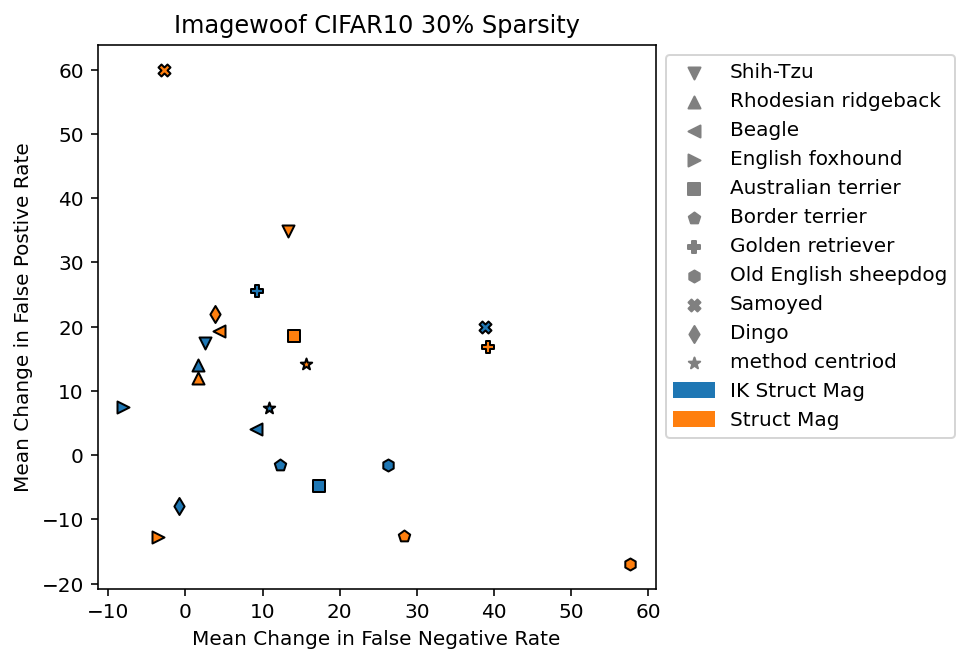

In [28]:
### FP Barchart

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import itertools

fig, ax = plt.subplots(figsize=(5,5))
m = ("v", "^", "<", ">", "s", "p", "P", "h", "X", "d", "*")
markers = itertools.cycle(m)

handles = []
for x, y in zip(FPN_IK_change, FPR_IK_change):
    handles.append(plt.scatter(x, y, marker=next(markers), c='#1f77b4', edgecolors='black'))
#plt.scatter(FPR_IK_change, FPN_IK_change)
handles.append(plt.scatter(np.mean(FPN_IK_change), np.mean(FPR_IK_change), marker=next(markers), c='#1f77b4', edgecolors='black'))
for x, y in zip(FPN_Struct_change, FPR_Struct_change):
    plt.scatter(x, y, marker=next(markers), c='#ff7f0e', edgecolors='black')
plt.scatter(np.mean(FPN_Struct_change), np.mean(FPR_Struct_change), marker=next(markers), c='#ff7f0e', edgecolors='black')
# plt.scatter(FPR_Struct_change, FPN_Struct_change)

handles.append(mpatches.Patch(color="#1f77b4", label='IK Struct Mag'))
handles.append(mpatches.Patch(color="#ff7f0e", label='Struct Mag'))
ax.legend(handles, class_names+['method centriod', 'IK Struct Mag', 'Struct Mag'], loc='best', bbox_to_anchor=(1, 1))
leg = ax.get_legend()
for handle in leg.legendHandles[:-2]:
    handle.set_color('grey')
plt.xlabel('Mean Change in False Negative Rate')
plt.ylabel('Mean Change in False Postive Rate')
plt.title("Imagewoof CIFAR10 30% Sparsity")
plt.show()


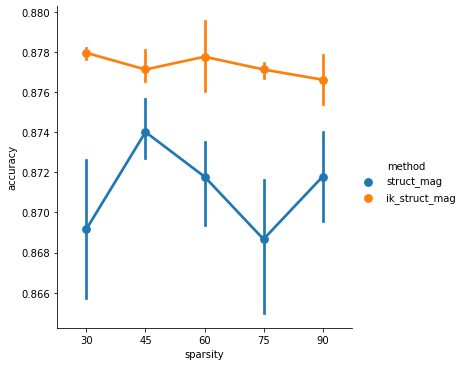

In [10]:
acc_plot = sns.catplot(x='sparsity', y='accuracy', hue='method', kind='point', data=dfs.pruning_stats)

acc_plot.savefig('figures/Acc_Struct_imagenette.jpg', dpi=600)
acc_plot.savefig('figures/Acc_Struct_imagenette.png', dpi=600)

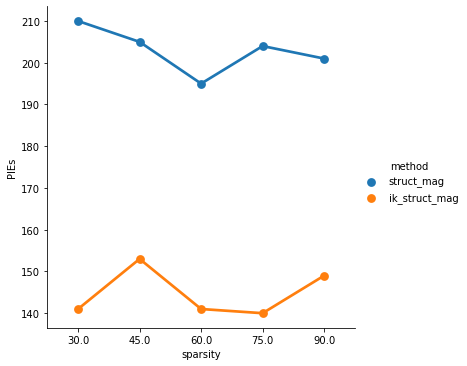

In [11]:
pie_fig = sns.catplot(x='sparsity', y='PIEs', hue='method', kind='point', data=dfs.PIEs)

pie_fig.savefig('figures/PIE_Struct_imagewoof.jpg', dpi=600)
pie_fig.savefig('figures/PIE_Struct_imagewoof.png', dpi=600)


In [12]:
sm, ik = dfs.pie_idx['struct_mag'][90], dfs.pie_idx['ik_struct_mag'][90]

In [13]:
ik_not_sm = np.nonzero(np.isin(ik, sm, invert=True))[0]
sm_not_ik = np.nonzero(np.isin(sm, ik, invert=True))[0]
inter = np.intersect1d(ik, sm)
print(f'struct PIES: {sm.size}')
print(f'ik PIES: {ik.size}')
print(f'# in fg not in ik: {sm_not_ik.size}')
print(f'# in ik not in fg: {ik_not_sm.size}')
print(f'intersection : {inter.size}')


struct PIES: 201
ik PIES: 149
# in fg not in ik: 112
# in ik not in fg: 60
intersection : 89


In [14]:
pwd

'/home/cody/inner-knowledge-pruning'

In [15]:
inter_ds = make_data_loader(1, dataset='imagewoof', subset=inter)
ik_ds = make_data_loader(1, dataset='imagewoof', subset=ik)
sm_ds = make_data_loader(1, dataset='imagewoof', subset=sm)

In [16]:
ground_labels_inter, teacher_pred_inter = class_report(teacher, inter_ds[0], inter_ds[1])
report_inter = classification_report(ground_labels_inter, 
                                     teacher_pred_inter, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_ik, teacher_pred_ik = class_report(teacher, ik_ds[0], ik_ds[1])
report_ik = classification_report(ground_labels_ik, 
                                     teacher_pred_ik, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_sm, teacher_pred_sm = class_report(teacher, sm_ds[0], sm_ds[1])
report_sm = classification_report(ground_labels_sm, 
                                     teacher_pred_sm, 
                                     target_names=class_names, 
                                     output_dict=True)

In [17]:
print(f'intersection accuracy {report_inter["accuracy"]}')
print(f'IK PIES accuracy {report_ik["accuracy"]}')
print(f'SM PIES accuracy {report_sm["accuracy"]}')

intersection accuracy 0.5955056179775281
IK PIES accuracy 0.6442953020134228
SM PIES accuracy 0.5970149253731343


In [18]:
dfs.pruning_stats

,accuracy,recall,f1-score,sparsity,method,full_report,false postives,false negatives,drift,FP_r,FN_r,drift_mod
0,0.866633,0.859378,0.860306,30,struct_mag,{'Australian terrier': {'precision': 0.8731343...,"[51, 60, 79, 46, 71, 41, 45, 25, 56, 50]","[58, 32, 70, 64, 46, 62, 55, 66, 9, 62]","[1.4038917892738492, 1.25, 1.3101160862354893,...","[1.186046511627907, 1.25, 1.1791044776119404, ...","[1.183673469387755, 1.0, 1.1111111111111112, 0...","[0.03417180825818701, 0.0, 0.01990049751243782..."
1,0.874268,0.865180,0.867091,30,struct_mag,{'Australian terrier': {'precision': 0.8694581...,"[53, 46, 76, 38, 62, 25, 53, 26, 52, 63]","[56, 35, 66, 71, 47, 63, 46, 52, 7, 51]","[1.4086378737541527, 1.0481770833333335, 1.188...","[1.2325581395348837, 0.9583333333333334, 1.134...","[1.1428571428571428, 1.09375, 1.04761904761904...","[0.03322259136212623, 0.0039062499999999965, 0..."
2,0.870960,0.861691,0.864314,30,struct_mag,{'Australian terrier': {'precision': 0.8298850...,"[74, 49, 88, 30, 71, 26, 49, 28, 54, 38]","[48, 33, 54, 73, 42, 71, 46, 65, 10, 65]","[1.6858092074038917, 1.052734375, 1.1257995735...","[1.7209302325581395, 1.0208333333333333, 1.313...","[0.9795918367346939, 1.03125, 0.85714285714285...","[0.014712861888941638, 0.0006510416666666644, ..."
3,0.864851,0.857290,0.857998,30,struct_mag,{'Australian terrier': {'precision': 0.8660049...,"[54, 60, 77, 50, 71, 20, 54, 34, 62, 49]","[60, 30, 73, 66, 43, 76, 48, 63, 9, 63]","[1.5377313716184149, 1.171875, 1.3316749585406...","[1.255813953488372, 1.25, 1.1492537313432836, ...","[1.2244897959183674, 0.9375, 1.158730158730158...","[0.057427622211675376, 0.015625, 0.02369106846..."
4,0.876559,0.868061,0.870241,45,struct_mag,{'Australian terrier': {'precision': 0.8578313...,"[59, 62, 87, 33, 65, 32, 48, 22, 42, 35]","[53, 28, 54, 68, 46, 58, 42, 60, 10, 66]","[1.4841006169909825, 1.1302083333333335, 1.113...","[1.372093023255814, 1.2916666666666667, 1.2985...","[1.0816326530612246, 0.875, 0.8571428571428571...","[0.03037494067394403, 0.03645833333333334, 0.0..."
5,0.874014,0.865179,0.867092,45,struct_mag,{'Australian terrier': {'precision': 0.8551068...,"[61, 51, 84, 37, 64, 20, 64, 28, 51, 35]","[49, 31, 59, 70, 44, 72, 40, 55, 8, 67]","[1.4186046511627908, 1.029296875, 1.1741293532...","[1.4186046511627908, 1.0625, 1.253731343283582...","[1.0, 0.96875, 0.9365079365079365, 0.985915492...","[0.0, 0.001953125, 0.016109926557687754, 0.002..."
6,0.872996,0.864833,0.867002,45,struct_mag,{'Australian terrier': {'precision': 0.8771929...,"[49, 48, 87, 33, 76, 31, 53, 26, 54, 42]","[59, 33, 58, 67, 44, 62, 44, 59, 9, 64]","[1.372093023255814, 1.03125, 1.195451314854299...","[1.1395348837209303, 1.0, 1.2985074626865671, ...","[1.2040816326530612, 1.03125, 0.92063492063492...","[0.028476506881822503, 0.0, 0.0236910684671878..."
7,0.872487,0.862550,0.865056,45,struct_mag,{'Australian terrier': {'precision': 0.8477751...,"[65, 47, 79, 31, 64, 30, 67, 29, 50, 39]","[47, 34, 63, 76, 46, 62, 41, 58, 9, 65]","[1.4499288087327955, 1.0403645833333333, 1.179...","[1.5116279069767442, 0.9791666666666666, 1.179...","[0.9591836734693877, 1.0625, 1.0, 1.0704225352...","[0.02088277171333652, 0.0013020833333333356, 0..."
8,0.874014,0.864846,0.867135,60,struct_mag,{'Australian terrier': {'precision': 0.8778625...,"[48, 52, 84, 32, 63, 42, 58, 30, 46, 40]","[64, 34, 58, 72, 44, 52, 40, 58, 11, 62]","[1.4579971523493116, 1.1510416666666665, 1.154...","[1.1162790697674418, 1.0833333333333333, 1.253...","[1.3061224489795917, 1.0625, 0.920634920634920...","[0.035595633602278104, 0.005208333333333329, 0..."
9,0.868160,0.861749,0.861834,60,struct_mag,{'Australian terrier': {'precision': 0.8498789...,"[62, 43, 75, 56, 72, 27, 49, 34, 54, 46]","[58, 35, 67, 59, 45, 72, 54, 56, 8, 64]","[1.7066919791172281, 0.9798177083333334, 1.190...","[1.441860465116279, 0.8958333333333334, 1.1194...","[1.183673469387755, 1.09375, 1.063492063492063...","[0.08115804461319409, 0.009765624999999997, 0...."


In [19]:
image, label = next(iter(inter_ds[0]['val']))

In [20]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torch.nn import Upsample


In [21]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [22]:
show(image)

ValueError: axes don't match array

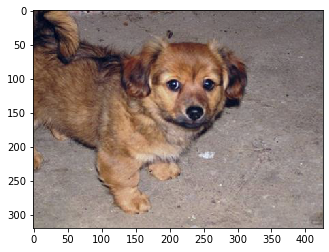

In [25]:
up = Upsample(scale_factor=16, mode='nearest')
for i, (image, label) in enumerate(inter_ds[0]['val']):
    show(make_grid(image, nrow=8, normalize=True))
    path = 'figures/PIE_images/'
    name = f'woof_pie_{i}_{class_names[label]}_{class_names[int(teacher_pred_inter[i])]}.jpg'
    save_image(image, normalize=True, fp=path+name)

In [ ]:
teacher_pred_inter[0]

In [27]:
pruning_stats = dfs.pruning_stats

In [28]:
struct_reports = list(pruning_stats.query('method == "struct_mag" & sparsity == 75')['full_report'])

In [35]:
struct_drift = list(pruning_stats.query('method == "struct_mag" & sparsity == 75')['drift'])

In [37]:
struct_drift

[array([1.40863787, 1.25      , 1.27694859, 0.88342823, 1.54553492,
        0.87382075, 1.71162791, 1.47058824, 1.48888889, 1.32464256]),
 array([1.54912197, 1.1484375 , 1.24449183, 0.73419239, 1.33333333,
        1.26120283, 1.74285714, 1.3092006 , 1.51428571, 1.08999159]),
 array([1.33270052, 1.12304688, 1.16038853, 0.63829787, 1.31564987,
        1.10377358, 1.49900332, 1.47058824, 1.22857143, 1.29184188]),
 array([1.48837209, 0.96875   , 1.405828  , 0.86335031, 1.34836428,
        1.09669811, 1.4910299 , 1.29411765, 1.58730159, 1.21867115])]

In [29]:
ik_reports = list(pruning_stats.query('method == "ik_struct_mag" & sparsity == 75')['full_report'])

In [36]:
ik_drift = list(pruning_stats.query('method == "ik_struct_mag" & sparsity == 75')['drift'])

In [42]:
ik_drift

[array([1.29473185, 1.18489583, 1.02037432, 0.82049745, 0.94827586,
        1.25471698, 1.51495017, 1.34690799, 1.67619048, 1.01682086]),
 array([1.23255814, 1.18164062, 1.08955224, 0.96913395, 1.0397878 ,
        0.98113208, 1.39534884, 1.16138763, 1.6       , 1.07148865]),
 array([1.22259136, 1.20833333, 1.19426676, 1.04405154, 1.19142352,
        1.18691038, 1.33953488, 0.94268477, 1.69206349, 0.84777124]),
 array([1.2529663 , 1.09375   , 1.0575693 , 0.9838178 , 1.14190981,
        1.35849057, 1.36345515, 1.15384615, 1.60952381, 1.06728343])]

In [30]:
from scipy import stats

In [31]:
for name in class_names:
    _, p = stats.ttest_ind([x[name]['precision'] for x in struct_reports], [x[name]['precision'] for x in ik_reports])
    if p < .05:
        print(name)

Samoyed


In [32]:
for name in class_names:
    _, p = stats.ttest_ind([x[name]['recall'] for x in struct_reports], [x[name]['recall'] for x in ik_reports])
    if p < .05:
        print(name)

Australian terrier
Rhodesian ridgeback
Golden retriever
Old English sheepdog


In [41]:
for i, name in enumerate(class_names):
    _, p = stats.ttest_ind([x[i] for x in struct_drift], [x[i] for x in ik_drift])
    if p < .05:
        print(name)


Australian terrier
Samoyed
Shih-Tzu
Rhodesian ridgeback
Dingo
Old English sheepdog


In [43]:
dfs.PIEs

,PIEs,method,sparsity
0,210.0,struct_mag,30.0
1,205.0,struct_mag,45.0
2,195.0,struct_mag,60.0
3,204.0,struct_mag,75.0
4,201.0,struct_mag,90.0
5,141.0,ik_struct_mag,30.0
6,153.0,ik_struct_mag,45.0
7,141.0,ik_struct_mag,60.0
8,140.0,ik_struct_mag,75.0
9,149.0,ik_struct_mag,90.0


In [1]:
import pickle

In [3]:
cd ..

/home/cody/inner-knowledge-pruning


In [46]:
with open("./pruning_stats/image_woof_struct.pickle", "wb") as f:
    pickle.dump(dfs, f)